In [1]:
!ln -s /data /habitat-api/data

ln: failed to create symbolic link '/habitat-api/data/data': File exists


In [2]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install sklearn
!pip install --upgrade wandb

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Requirement already up-to-date: wandb in /opt/conda/lib/python3.7/site-packages (0.8.25)


In [3]:
!wandb login

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import habitat
import numpy as np
from tqdm.notebook import tqdm, trange
import torch
import matplotlib.pyplot as plt
import random
import torch.nn as nn
# from tensorboardX import SummaryWriter
from Vec_env import create_envs
from Utils import AverageMeter, DepthNorm
from Data import getTrainTestData
from Model_dense import Model
from Loss import ssim
import wandb
import os

In [5]:
%cd ../../habitat-api/
%ls

/habitat-api
CODE_OF_CONDUCT.md  README.md  habitat/            res/
CONTRIBUTING.md     configs/   habitat.egg-info/   setup.cfg
Dockerfile          data@      habitat_baselines/  setup.py
LICENSE             docs/      pyproject.toml      test/
MANIFEST.in         examples/  requirements.txt    wandb/


In [6]:
# config = habitat.get_config(config_paths='configs/tasks/pointnav_gibson.yaml')
# config.defrost()
# config.DATASET.DATA_PATH = 'data/datasets/pointnav/gibson/v1/val/val.json.gz'
# config.freeze()
# envs = create_envs(1, config)

#### Create net

In [7]:
net = Model()

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(device)

cuda:0


#### Import datasets

In [9]:
batch_size = 8
train_data, test_data = getTrainTestData(batch_size, 'data/My_data')

Loading dataset Loaded (20804)
Loading dataset Loaded (10996)


#### Train on collected dataset

Epoch: [0][0/2601] : train_loss = 1.9035 (1.9035)



Epoch: [0][0/2601] : test_loss = 6168.8782


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: [0][5/2601] : train_loss = 1.8188 (1.9463)
Epoch: [0][10/2601] : train_loss = 0.6736 (1.8395)
Epoch: [0][15/2601] : train_loss = 1.5645 (1.7196)
Epoch: [0][20/2601] : train_loss = 1.1336 (1.1178)
Epoch: [0][25/2601] : train_loss = 1.0153 (1.1334)
Epoch: [0][30/2601] : train_loss = 1.3909 (1.2769)
Epoch: [0][35/2601] : train_loss = 1.0941 (1.0610)
Epoch: [0][40/2601] : train_loss = 1.1838 (1.2001)
Epoch: [0][45/2601] : train_loss = 1.3464 (1.2827)
Epoch: [0][50/2601] : train_loss = 1.5116 (1.4339)
Epoch: [0][55/2601] : train_loss = 0.7120 (1.0049)
Epoch: [0][60/2601] : train_loss = 0.9914 (1.2389)
Epoch: [0][65/2601] : train_loss = 1.2347 (0.9848)
Epoch: [0][70/2601] : train_loss = 0.5807 (0.9113)
Epoch: [0][75/2601] : train_loss = 1.0508 (0.8642)
Epoch: [0][80/2601] : train_loss = 0.7861 (0.8011)
Epoch: [0][85/2601] : train_loss = 1.0271 (1.2302)
Epoch: [0][90/2601] : train_loss = 1.2230 (1.1499)
Epoch: [0][95/2601] : train_loss = 1.3870 (1.1516)
Epoch: [0][100/2601] : train_los


Epoch: [0][300/2601] : test_loss = 6.1658
Epoch: [0][305/2601] : train_loss = 1.1097 (0.8272)
Epoch: [0][310/2601] : train_loss = 1.2927 (1.0617)
Epoch: [0][315/2601] : train_loss = 0.9031 (0.9379)
Epoch: [0][320/2601] : train_loss = 0.7622 (0.7695)
Epoch: [0][325/2601] : train_loss = 1.5455 (1.2980)
Epoch: [0][330/2601] : train_loss = 1.1226 (1.2874)
Epoch: [0][335/2601] : train_loss = 0.7503 (0.9937)
Epoch: [0][340/2601] : train_loss = 1.0984 (0.7200)
Epoch: [0][345/2601] : train_loss = 1.1115 (1.0755)
Epoch: [0][350/2601] : train_loss = 1.3402 (1.0066)
Epoch: [0][355/2601] : train_loss = 0.6311 (0.8507)
Epoch: [0][360/2601] : train_loss = 1.4689 (1.0243)
Epoch: [0][365/2601] : train_loss = 0.6831 (1.3470)
Epoch: [0][370/2601] : train_loss = 1.3266 (0.9698)
Epoch: [0][375/2601] : train_loss = 1.2745 (0.8924)
Epoch: [0][380/2601] : train_loss = 1.6580 (0.9619)
Epoch: [0][385/2601] : train_loss = 1.6644 (1.1470)
Epoch: [0][390/2601] : train_loss = 0.5909 (0.9265)
Epoch: [0][395/2601] 

KeyboardInterrupt: 

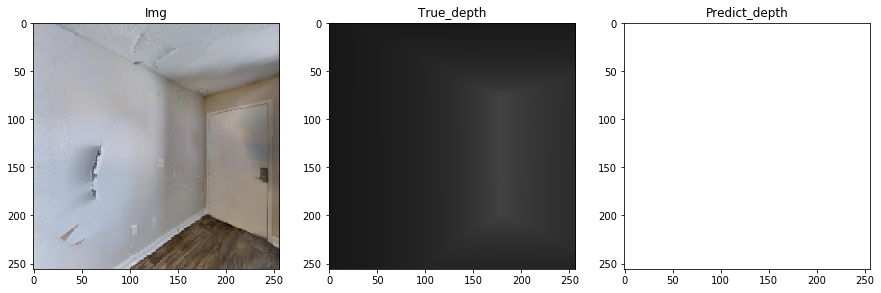

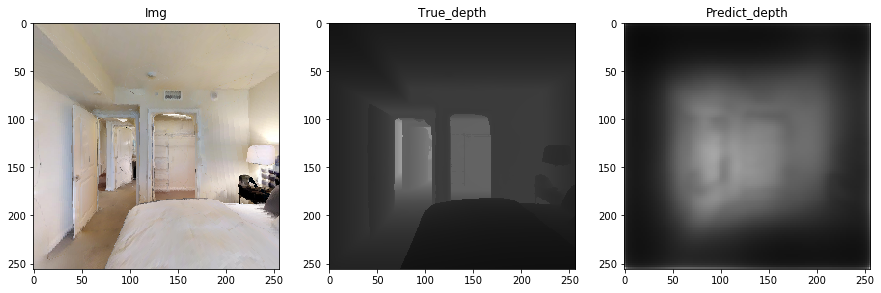

In [10]:
# import copy

# Logging
wandb.init(project="mapper", entity='stepan-makarenko')
wandb.watch(net)

def train(net, train_loader, test_loader):
    
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    N = len(train_loader)
    
    net.to(device)
    losses_train = AverageMeter()
    losses_test = AverageMeter()
    
    best_test_loss = float(np.inf)
#     best_model = copy.deepcopy(net)
        
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999))
    l1_criterion = nn.L1Loss()
    
    for epoch in trange(80):
        
        for i, sample_batched in tqdm(enumerate(train_loader)):

            # Prepare sample and target
            image = torch.autograd.Variable(sample_batched['image'].to(device))
            depth = torch.autograd.Variable(sample_batched['depth'].to(device, non_blocking=True))

            # Normalize depth
            depth_n = DepthNorm(depth)
            
            optimizer.zero_grad()
            net.train()
            
            output = net.forward(image)
            output = nn.functional.interpolate(output, (256, 256))
            
            l_depth = l1_criterion(output, depth_n)
            l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)
            loss = (1.0 * l_ssim) + (0.1 * l_depth)
            losses_train.update(loss.data.item(), image.size(0))
            
            loss.backward()
            optimizer.step()
            
            # Log progress
            niter = epoch*N+i
            if i % 5 == 0:
                # Print to console
                print('Epoch: [{0}][{1}/{2}] : train_loss = {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, loss=losses_train))
                
                # Log to WB
                wandb.log({'Iteration': niter, 'Train loss': losses_train.val})
                
                losses_train.reset()
            
            if i % 300 == 0:
                with torch.no_grad():
                    net.eval()
                    for j, sample_batched in tqdm(enumerate(test_loader)):
                        optimizer.zero_grad()

                        # Prepare sample and target
                        image = torch.autograd.Variable(sample_batched['image'].to(device))
                        depth = torch.autograd.Variable(sample_batched['depth'].to(device, non_blocking=True))

                        # Normalize depth                
                        output = DepthNorm(net.forward(image))
                        output = nn.functional.interpolate(output, (256, 256))

                        l_depth = l1_criterion(output, depth)
                        l_ssim = torch.clamp((1 - ssim(output, depth, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)
                        loss = (1.0 * l_ssim) + (0.1 * l_depth)
                        losses_test.update(loss.data.item(), image.size(0))

                    if losses_test.avg < best_test_loss:
#                         torch.save(net.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))
                        torch.save(net.state_dict(), "model.pt")
                        wandb.save('model.pt')
#                         torch.save(net.state_dict(), 'best_net.pt')
#                         best_model = copy.deepcopy(net)
                        best_test_loss = losses_test.avg
                        
                    # Print to console
                print('Epoch: [{0}][{1}/{2}] : test_loss = {loss.avg:.4f}'.format(epoch, i, N, loss=losses_test))

                # Log to WB
                wandb.log({'Iteration': niter, 'Test loss': losses_test.avg})
                
                ### Image save
                scen_num = np.random.randint(batch_size)
                for d in test_data:
                    x = d['image'][scen_num]
                    y = d['depth'][scen_num] / 1000
                    x = x.permute(1,2,0)
                    y = y.permute(1,2,0)
                    break
                    
                d = d['image'].to(device)
                my_depth=net.forward(d)
                my_depth = nn.functional.interpolate(my_depth, (256, 256))
                my_depth = my_depth.permute(0, 2, 3, 1)
                my_depth_numpy = my_depth.cpu().detach().numpy()[scen_num]

                fig = plt.figure(figsize=(15,15))
                a = fig.add_subplot(1, 3, 1)
                imgplot = plt.imshow(x)
                a.set_title('Img')
                a = fig.add_subplot(1, 3, 2)
                imgplot = plt.imshow(np.concatenate((y, y, y), axis=2))
                a.set_title('True_depth')
                a = fig.add_subplot(1, 3, 3)
                imgplot = plt.imshow(np.concatenate((1/my_depth_numpy, 1/my_depth_numpy, 1/my_depth_numpy), axis=2))
                a.set_title('Predict_depth')

                wandb.log({'Iteration': niter, 'Example depth': wandb.Image(fig)})
                ###
                
                losses_test.reset()
            

    return net

net = train(net, train_data, test_data)